In [40]:
import os
import time
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torchvision import datasets, transforms

In [41]:
# Check if GPU is available
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:3


In [42]:
cifar_train = datasets.CIFAR10('./data', train=True, download=True ,transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10('./data', train=False, download=True ,transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [65]:

val_ratio = 0.2
val_size = int(len(cifar_train) * val_ratio)
train_size = len(cifar_train) - val_size
# Split the training subset into new train and validation sets
train_split, val_split = random_split(cifar_train, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_split, batch_size=64, shuffle=True)
val_loader = DataLoader(val_split, batch_size=64, shuffle=False)
test_loader = DataLoader(cifar_test, batch_size=64, shuffle=False)

# Optional: check shapes
X_train, y_train = next(iter(train_loader))
X_val, y_val = next(iter(val_loader))
X_test, y_test = next(iter(test_loader))

print(f"Train batch shape: {X_train.shape}")
print(f"Validation batch shape: {X_val.shape}")
print(f"Test batch shape: {X_test.shape}")


Train batch shape: torch.Size([64, 3, 32, 32])
Validation batch shape: torch.Size([64, 3, 32, 32])
Test batch shape: torch.Size([64, 3, 32, 32])


In [66]:
class LeNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, input_size=(32, 32)):
        """
        LeNet Extended to work on any input size
        Args:
            in_channels: Number of channels in input image
            num_classes: Number of output classes
            input_size: Tuple of (H, W) for input image size
        """
        super(LeNet, self).__init__()

        # ---- Convolutional layers ----
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5, stride=1, padding=2)  # preserves spatial size
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # reduces size
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)  # classic LeNet fully connected conv

        # ---- Compute flatten size dynamically ----
        dummy_input = torch.zeros(1, in_channels, input_size[0], input_size[1])
        dummy_out = self._forward_features(dummy_input)
        flatten_dim = dummy_out.view(1, -1).size(1)

        # ---- Fully connected layer ----
        self.fc1 = nn.Linear(flatten_dim, num_classes)

    def _forward_features(self, x):
        # Layer 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        # Layer 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Layer 3 (like LeNet-5)
        x = F.relu(self.conv3(x))
        return x

    def forward(self, x):
        # Extract features
        x = self._forward_features(x)

        # Flatten
        x = torch.flatten(x, 1)

        # Fully connected
        logits = self.fc1(x)

        # Return logits and log probabilities
        return logits, F.log_softmax(logits, dim=1)

In [67]:
# Hyperparameters
lr = 0.01
batch_size = 64
num_epoch = 10
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [68]:
lenet_model = LeNet(in_channels=3, num_classes=10, input_size=(32, 32))
lenet_model = lenet_model.to(device)
optimizer = torch.optim.SGD(lenet_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [69]:
print(lenet_model)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=480, out_features=10, bias=True)
)


In [70]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(model, train_loader=train_loader):
    lenet_model.train()                                      # sets model to training mode (dropout and batchnorm behaves in this mode)
    train_corr, train_total, train_running_loss = 0, 0, 0  # counters for tracting trainning accuracy, total examples, running loss

    for step, (data, y) in enumerate(train_loader):        # loops over batch of data in train_loader
        data, y = data.to(device), y.to(device)
        optimizer.zero_grad()                                # resets gradients to prevent accumulation
        _, logits = lenet_model(data)                          # gets the logits 
        loss = loss_fn(logits, y)                            # calculates loss comparing with true label
        loss.backward()                                      # back propagation is performed to compute gradients
        optimizer.step()                                     # optimizer updates model params

        y_pred = torch.argmax(logits, 1)                     # selects the predicted class (the index with the highest value)
        train_corr += torch.sum(torch.eq(y_pred, y).float()).item()      # counts correct predictions
        train_total += len(data)                             # tracks total no. of samples
        train_running_loss += loss.item()                    # accumulates loss
    
    # Calculate average loss and accuracy for this epoch
    epoch_loss = train_running_loss / len(train_loader)
    epoch_accuracy = train_corr / train_total

    # Append to lists for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}] Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
####################################################################################################################
   
def test(test_loader=test_loader):
    lenet_model.eval()                                        # sets model to evalutaion mode
    test_corr, test_total, test_running_loss = 0, 0, 0
    with torch.no_grad():
        for step, (data, y) in enumerate(test_loader):
            data, y = data.to(device), y.to(device)
            _, logits = lenet_model(data)
            loss = loss_fn(logits, y)
            y_pred = torch.argmax(logits, 1)
            test_corr += torch.sum(torch.eq(y_pred, y).float()).item()
            test_total += len(data)
            test_running_loss += loss.item()
    # Calculate average loss and accuracy for this epoch
    epoch_loss = test_running_loss / len(test_loader)
    epoch_accuracy = test_corr / test_total

    # Append to lists for plotting
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}] Valid/Test Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

In [71]:
for epoch in range(num_epoch):
  print(f"--------- Train EPOCH {epoch} -------------")
  train(train_loader)
  print(f"--------- Valid EPOCH {epoch} -------------")
  test(val_loader)

--------- Train EPOCH 0 -------------
Epoch [1] Train Loss: 2.2873, Accuracy: 0.1352
--------- Valid EPOCH 0 -------------
Epoch [1] Valid/Test Loss: 2.2101, Accuracy: 0.2338
--------- Train EPOCH 1 -------------
Epoch [2] Train Loss: 2.0294, Accuracy: 0.2601
--------- Valid EPOCH 1 -------------
Epoch [2] Valid/Test Loss: 1.9383, Accuracy: 0.3065
--------- Train EPOCH 2 -------------
Epoch [3] Train Loss: 1.8902, Accuracy: 0.3238
--------- Valid EPOCH 2 -------------
Epoch [3] Valid/Test Loss: 1.8262, Accuracy: 0.3455
--------- Train EPOCH 3 -------------
Epoch [4] Train Loss: 1.7863, Accuracy: 0.3633
--------- Valid EPOCH 3 -------------
Epoch [4] Valid/Test Loss: 1.7430, Accuracy: 0.3867
--------- Train EPOCH 4 -------------
Epoch [5] Train Loss: 1.6923, Accuracy: 0.3981
--------- Valid EPOCH 4 -------------
Epoch [5] Valid/Test Loss: 1.6611, Accuracy: 0.4064
--------- Train EPOCH 5 -------------
Epoch [6] Train Loss: 1.6128, Accuracy: 0.4270
--------- Valid EPOCH 5 -------------
Ep

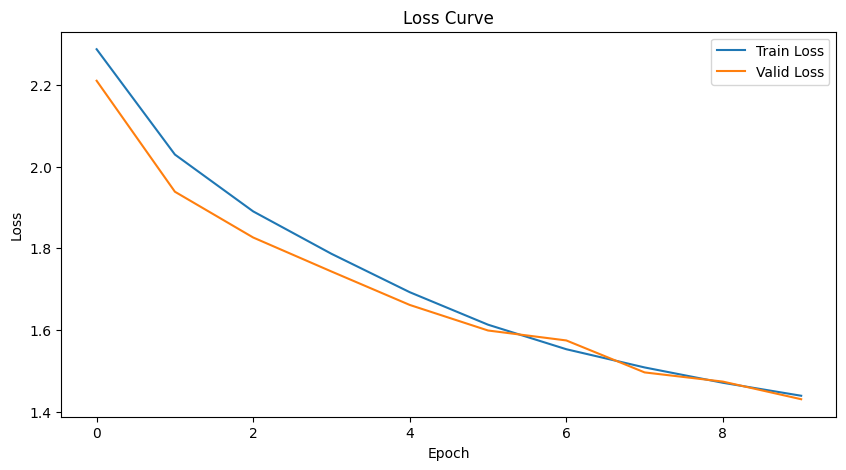

In [72]:
# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Valid Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

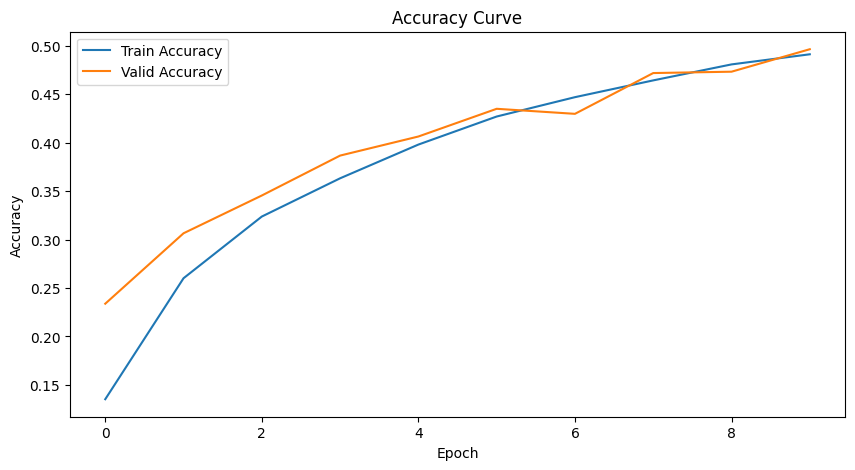

In [73]:
# Plot the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Valid Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [74]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, data_loader, device, num_images=10, cmap='gray'):
    """
    Visualize predictions vs ground truth from a model and data loader.

    Args:
        model: PyTorch model
        data_loader: DataLoader containing the dataset
        device: torch.device
        num_images: number of images to display
        cmap: colormap for plotting (use 'gray' for single-channel images)
    """
    model.eval()  # set model to evaluation mode
    
    # Fetch one batch
    data, labels = next(iter(data_loader))
    data, labels = data.to(device), labels.to(device)
    
    # Forward pass
    with torch.no_grad():
        logits, _ = model(data)  # get logits
        y_pred = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)  # convert logits to probabilities
    
    # Determine number of images to show
    num_images = min(num_images, data.size(0))
    
    # Plot
    fig = plt.figure(figsize=(15, 6))
    
    for i in range(num_images):
        plt.subplot(2, (num_images + 1)//2, i+1)
        
        img = data[i].cpu().detach()
        
        # Handle 1-channel and 3-channel images
        if img.shape[0] == 1:
            plt.imshow(img.squeeze(0).numpy(), cmap=cmap)
        elif img.shape[0] == 3:
            # Convert from CxHxW to HxWxC
            plt.imshow(img.permute(1,2,0).numpy())
        else:
            raise ValueError(f"Unsupported number of channels: {img.shape[0]}")
        
        # Title with GT, prediction, and confidence
        plt.title(
            f"GT: {labels[i].cpu().item()}\n"
            f"Pred: {y_pred[i].cpu().item()}\n"
            f"Conf: {probs[i, y_pred[i]]*100:.2f}%"
        )
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.show()


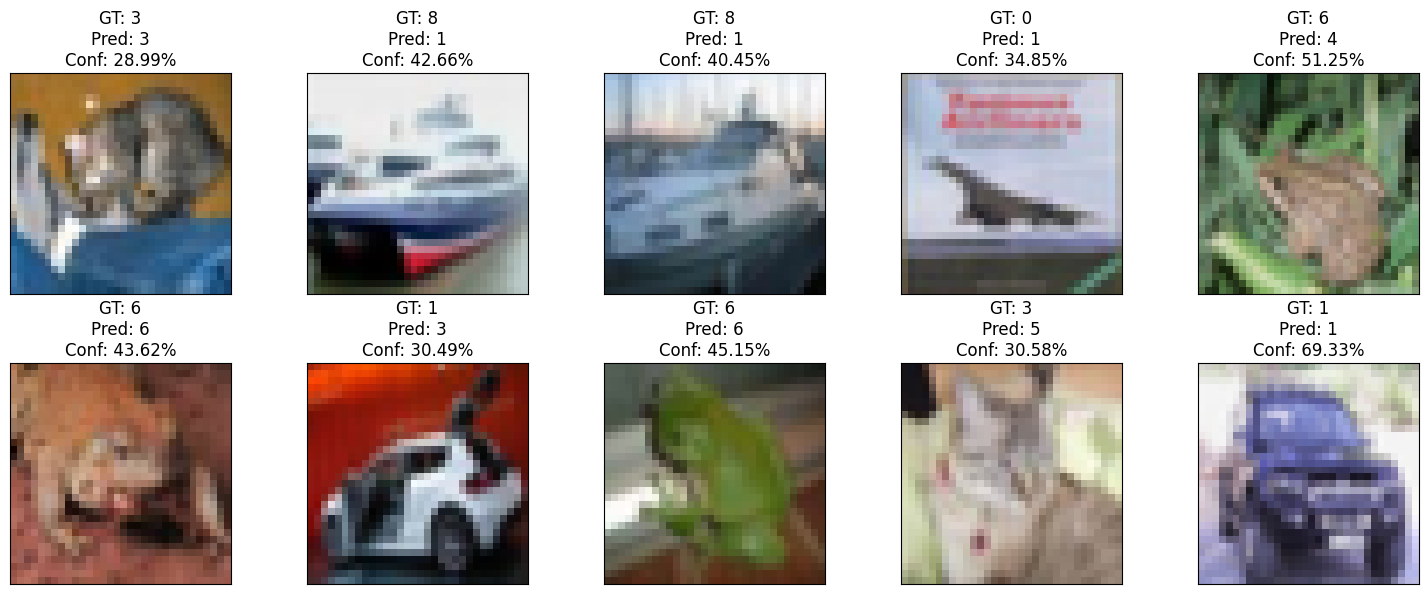

In [75]:
# Example usage with CIFAR-10 or MNIST
visualize_predictions(
    model=lenet_model,
    data_loader=test_loader,
    device=device,
    num_images=10
)
